In [1]:
import numpy.random as random
import numpy as np
import sys
from scipy import signal
from scipy.special import j0
from scipy.special import j1
from scipy.special import jn_zeros

import matplotlib.cm as cm
from matplotlib import pyplot as plt

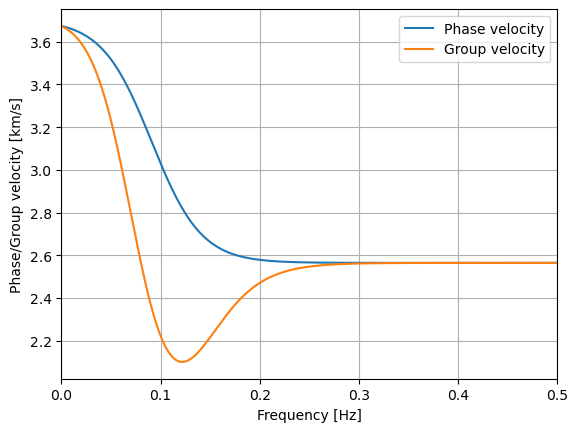

In [2]:
def cal_disp(freq):
    freq0 = 0.1
    p = np.tanh((freq-freq0)*20)*0.06+0.33
    return 1./p, 1/(freq*0.06*20/(np.cosh((freq-freq0)*20))**2+p)

Δt = 1.
length = 1024
freq0 = 0.1
Δf = 1./(length*Δt)
t_ary = np.arange(0,length)
f_ary = np.arange(length//2+1)*Δf
ω_ary = f_ary*2*np.pi

cp,cg = np.array([cal_disp(freq) for freq in f_ary]).T
k = 2*np.pi*f_ary/cp

plt.plot(f_ary,cp,label="Phase velocity")
plt.plot(f_ary,cg,label="Group velocity")
plt.grid()
plt.xlim(0,0.5)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase/Group velocity [km/s]")
plt.legend()

# Synthetic data

* The separation distance $\Delta$ is 150 km.
* $J_0(k(\omega)\Delta)+n(\omega)$ in frequency domain.
* Standard deviation of noise $n$ is 0.01.
* We show a synthetic seismogram in time domain below.

Text(0.5, 0, 'Lag time [s]')

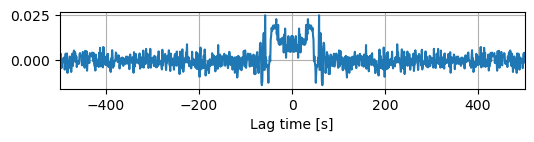

In [81]:
Δ=150
plt.figure(figsize=(6,1))
spctrm = j0(k*Δ)+np.random.randn(len(k))*10E-2
plt.plot(np.arange(-512,512),np.fft.fftshift(np.fft.irfft(spctrm)))
plt.grid()
plt.xlim(-500,500)
plt.xlabel("Lag time [s]")

# Group velocity filter

This filter suppresses components with slower group velocity than $gv$.

In [95]:
def filter_gv(spctrm,gv,Δ):
    length = len(spctrm)
    it0,it1 = int(Δ/gv),int(Δ/(gv*0.75))
    sgram = np.fft.irfft(spctrm)
    win = np.cos(np.arange(it1-it0)/(it1-it0)*np.pi/2)**2
    sgram[it0:it1] *= win
    sgram[-it1:-it0] *= win[::-1]
    sgram[it1:-it1] =  0.
    spctrm_gv = np.real(np.fft.fft(sgram))
    return spctrm_gv



# Phase velocity measurments by zero-crossing method (Ekstrom et al. 2009)

* Pick up the zeros of the real part of the cross spectrum.
* We distinguish zeros with positive slopes from those with negative slopes.
* The group velcity filter reduces the noise of the cross spectrum.
* Missing zeros cause ambiguity of the phase velcity measurements. To correct the missing zeros, we also show branches allowing the number of missed or extra zero crossings.

Text(0, 0.5, 'Phase velocity [km/s]')

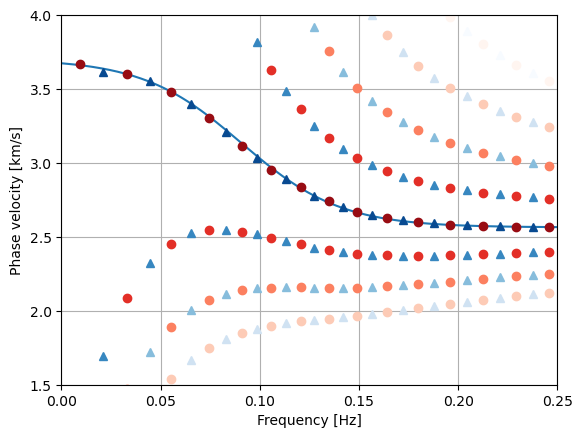

In [101]:
Δ=150
zn = jn_zeros(0,10000)
cmap_r = plt.get_cmap('Reds')
cmap_b = plt.get_cmap('Blues')

plt.plot(f_ary,cp)
dcp_all = []
df_all=[]
cp_obs = 0.
for loop in range(1):
    count = 0
    fp = 0.
    fobs=0.
    cp_p = 0
    spctrm = j0(k*Δ)+np.random.randn(len(k))*1E-2 #Synthetic cross spectrum
    spctrm = filter_gv(spctrm,2.5,Δ)
    for i in range(len(f_ary)//2-1):
        if spctrm[i] >= 0 and spctrm[i+1] < 0: #Negative slope at the zero
            fp = fobs
            cp_p = cp_obs
            fobs =  Δf*(i+abs(spctrm[i])/(abs(spctrm[i])+abs(spctrm[i+1])))
            cp_obs = Δ*2*np.pi*fobs/zn[count]
            if count >=0 : 
                for nn in range(-8,8,2): 
                    if count + nn < 0: continue
                    if abs(cal_disp(fobs)[0]-Δ*2*np.pi*fobs/zn[count+nn]) < abs(cal_disp(fobs)[0]-cp_obs): cp_obs=Δ*2*np.pi*fobs/zn[count+nn]
                    plt.plot(fobs,Δ*fobs*2*np.pi/zn[count+nn],"o",color=cmap_r(230-abs(nn)*30))
            count += 1
        if spctrm[i] <= 0 and spctrm[i+1] > 0: #Positive slope at the zero
            fp=fobs
            cp_p = cp_obs
            fobs =  Δf*(i+abs(spctrm[i])/(abs(spctrm[i])+abs(spctrm[i+1])))
            cp_obs = Δ*2*np.pi*fobs/zn[count]
            if count >= 0: 
                for nn in range(-8,8,2): 
                    if count+nn < 0: continue
                    if abs(cal_disp(fobs)[0]-Δ*2*np.pi*fobs/zn[count+nn]) < abs(cal_disp(fobs)[0]-cp_obs): cp_obs=Δ*2*np.pi*fobs/zn[count+nn]
                    plt.plot(fobs,Δ*fobs*2*np.pi/zn[count+nn],"^",color=cmap_b(230-abs(nn)*30))
            count += 1
plt.ylim(1.5,4)
plt.xlim(0.,0.25)
plt.grid()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase velocity [km/s]")


* Red: negative slope
* Blue: positive slope
* We show the darker the color for the fewer the MISSING ZEROS.